В данном ноутбуке мы используем средний по величине (количеству деревьев) классификатор типа RandomForest для предсказания успешности прохождения пользователем онлайн-курса на платформе [Stepik](https://stepik.org/) по информации о его поведении в первые 2 дня прохождения.

В качестве обрабатываемых данных возьмем данные об активности студентов онлайн курса [Введение в анализ данных в R](https://stepik.org/course/129/syllabus)

Для обучения классификатора возьмем данные о действиях, которые совершают студенты со стэпами [events_train.csv](https://stepik.org/media/attachments/course/4852/event_data_train.zip) и данные о времени и статусах отправок решений к практическим заданиям [submissions_train.csv](https://stepik.org/media/attachments/course/4852/submissions_data_train.zip)

Для проверки работоспособности классификатора возьмем аналогичного рода наборы данных, только за более поздний период [events_data_test.csv](https://stepik.org/media/attachments/course/4852/events_data_test.csv) и [submission_data_test.csv](https://stepik.org/media/attachments/course/4852/submission_data_test.csv)

В качестве критерия проверки возьмем метрику [ROC AUC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html), в качестве проверяемого результата используем csv файл c предсказанием для каждого студента из тестовых данных (будет состоять из id студента и его шанса ухода с курса без полного прохождения). Пример предсказания выглядит [следующим образом](https://stepik.org/media/attachments/course/4852/submission_example.csv).

Импортируем нужные библиотеки:

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
sns.set(rc={'figure.figsize': (9, 6)})

# Предобработка и анализ тренировочных данных

Считаем данные о действиях, совершаемых со степами

In [5]:
events_train = pd.read_csv('data/event_data_train.zip')
events_train.head(10)

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632
5,32811,1434340895,passed,17632
6,32929,1434340921,discovered,17632
7,32929,1434340921,viewed,17632
8,32929,1434340939,started_attempt,17632
9,32929,1434340944,passed,17632


Введем колонку с датой в более удобочитаемом формате

In [6]:
events_train['date'] = pd.to_datetime(events_train.timestamp, unit='s')
events_train.head(10)

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35
5,32811,1434340895,passed,17632,2015-06-15 04:01:35
6,32929,1434340921,discovered,17632,2015-06-15 04:02:01
7,32929,1434340921,viewed,17632,2015-06-15 04:02:01
8,32929,1434340939,started_attempt,17632,2015-06-15 04:02:19
9,32929,1434340944,passed,17632,2015-06-15 04:02:24


Выделим из полной даты только дни

In [7]:
events_train['day'] = events_train.date.dt.date
events_train.head(10)

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15
5,32811,1434340895,passed,17632,2015-06-15 04:01:35,2015-06-15
6,32929,1434340921,discovered,17632,2015-06-15 04:02:01,2015-06-15
7,32929,1434340921,viewed,17632,2015-06-15 04:02:01,2015-06-15
8,32929,1434340939,started_attempt,17632,2015-06-15 04:02:19,2015-06-15
9,32929,1434340944,passed,17632,2015-06-15 04:02:24,2015-06-15


Посмотрим, сколько пользователей открыло разные количества степов

<Axes: >

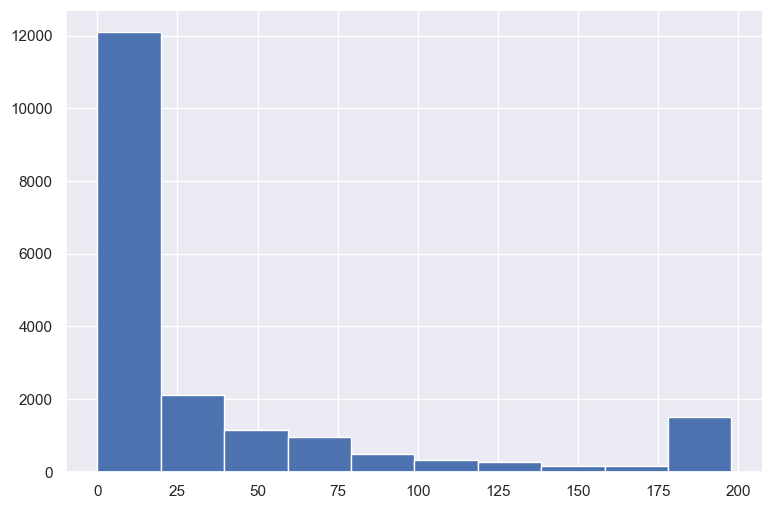

In [8]:
events_train.pivot_table(index='user_id', 
                        columns='action', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index().discovered.hist()

Как видим, большинство пользователей закончили работу с курсом, пройдя менее 25 степов

Преподготовим и проанализируем данные об отправках решений задач пользователями (сделаем аналогичные преобразования, что и для набора данных с событиями)

In [9]:
submissions_train = pd.read_csv('data/submissions_data_train.zip')
submissions_train.head(10)

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853
5,31976,1434348188,correct,15853
6,31976,1478852055,correct,15853
7,31977,1434347371,correct,15853
8,31978,1434349981,correct,15853
9,31979,1434446091,correct,15853


In [10]:
submissions_train['date'] = pd.to_datetime(submissions_train.timestamp, unit='s')
submissions_train.head(10)

,step_id,timestamp,submission_status,user_id,date
0,31971,1434349275,correct,15853,2015-06-15 06:21:15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49
3,31972,1478852164,correct,15853,2016-11-11 08:16:04
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03
5,31976,1434348188,correct,15853,2015-06-15 06:03:08
6,31976,1478852055,correct,15853,2016-11-11 08:14:15
7,31977,1434347371,correct,15853,2015-06-15 05:49:31
8,31978,1434349981,correct,15853,2015-06-15 06:33:01
9,31979,1434446091,correct,15853,2015-06-16 09:14:51


In [11]:
submissions_train['day'] = submissions_train.date.dt.date
submissions_train.head(10)

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15
5,31976,1434348188,correct,15853,2015-06-15 06:03:08,2015-06-15
6,31976,1478852055,correct,15853,2016-11-11 08:14:15,2016-11-11
7,31977,1434347371,correct,15853,2015-06-15 05:49:31,2015-06-15
8,31978,1434349981,correct,15853,2015-06-15 06:33:01,2015-06-15
9,31979,1434446091,correct,15853,2015-06-16 09:14:51,2015-06-16


Посмотрим, сколько пользователей набрали разные количества баллов

In [12]:
users_scores = submissions_train.pivot_table(index='user_id', 
                        columns='submission_status', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()
users_scores.head(10)

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1
5,16,77,106
6,17,0,2
7,22,76,47
8,25,1,4
9,26,7,16


Определим пороговое число дней, неактивность на протяжении которых будет означать уход с курса

Для каждого пользователя посчитаем перерывы между двумя последними заходами на курс

In [13]:
gap_data = events_train[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day'])\
    .groupby('user_id')['timestamp']\
    .apply(list)\
    .apply(np.diff)\
    .values
gap_data

array([array([], dtype=int32), array([4843602]),
       array([6899249,  182484,   93710, 2768870,  171400,   78712]), ...,
       array([   86128,   136759,    94899,  1422583, 14347289,   505061,
                 98252,    57019])                                       ,
       array([1567990]), array([], dtype=int32)], dtype=object)

Приведем к более удобочитаемому формату

In [14]:
gap_data = pd.Series(np.concatenate(gap_data, axis=0))
gap_data

0         4843602
1         6899249
2          182484
3           93710
4         2768870
           ...   
97867    14347289
97868      505061
97869       98252
97870       57019
97871     1567990
Length: 97872, dtype: int32

Представим результат в днях

In [15]:
gap_data /= (24 * 60 * 60)
gap_data

0         56.060208
1         79.852419
2          2.112083
3          1.084606
4         32.047106
            ...    
97867    166.056586
97868      5.845613
97869      1.137176
97870      0.659942
97871     18.148032
Length: 97872, dtype: float64

<Axes: >

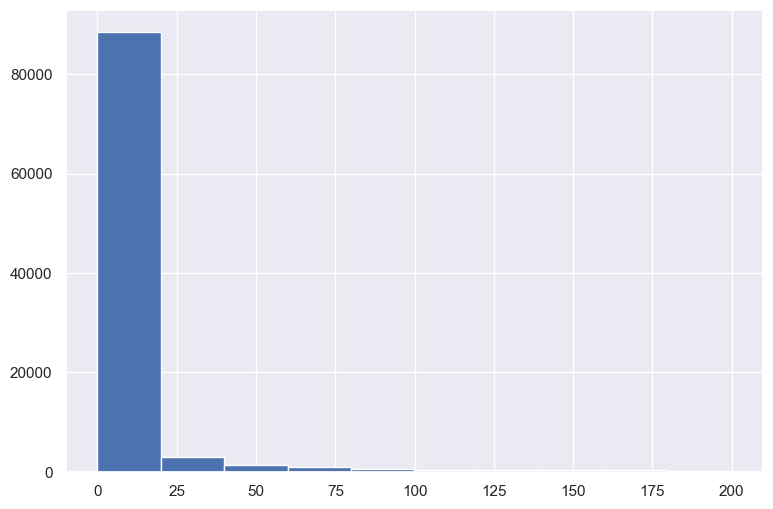

In [16]:
gap_data[gap_data < 200].hist()

Как видно, наиболее частые промежутки в заходах на курс составляют от 0 до 25 дней

Посчитаем среднее между 95-м и 90-м процентилем, чтобы узнать, после скольки дней перерыва с курса уходят 90 - 95% пользователей

In [17]:
days_drop_out_threshold = int(np.mean([gap_data.quantile(0.9), gap_data.quantile(0.95)]))
days_drop_out_threshold

39

Пусть время максимально допустимой неактивности пользователя составит 39 дней, а в качестве крайнего момента возьмем последний timestamp из датасета. В качестве критерия успешного прохождения курса возьмем факт решения пользователем более 40-ка задач. 

Определим константы:

In [18]:
final_timestamp = int(events_train.tail(1).timestamp)
drop_out_threshold = days_drop_out_threshold * 24 * 60 * 60
score_for_success = 40

Посчитаем для каждого пользователя время его последнего доступа к курсу

In [19]:
users_data = events_train.groupby('user_id', as_index=False).agg(last_timestamp = ('timestamp', 'max'))
users_data.head(10)

,user_id,last_timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660
5,8,1481466913
6,9,1484999497
7,11,1526140625
8,14,1436368676
9,16,1513162585


Если пользователь не заходил на курс более 39 дней (относительно крайней дате в наборе данных), будем считать его ушедшим с курса

In [20]:
users_data['is_gone'] = (final_timestamp - users_data.last_timestamp) > drop_out_threshold
users_data.head(10)

,user_id,last_timestamp,is_gone
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True
5,8,1481466913,True
6,9,1484999497,True
7,11,1526140625,False
8,14,1436368676,True
9,16,1513162585,True


Объединим информацию о завершении курса с информацией о попытках решения заданий

In [21]:
users_data = users_data.merge(users_scores, on='user_id', how='outer').fillna(0)
users_data.head(10)

,user_id,last_timestamp,is_gone,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0
5,8,1481466913,True,9.0,21.0
6,9,1484999497,True,0.0,0.0
7,11,1526140625,False,0.0,0.0
8,14,1436368676,True,0.0,1.0
9,16,1513162585,True,77.0,106.0


Получим сводную таблицу с информацией о действиях студентов со степами

In [22]:
users_events_data = events_train.pivot_table(index='user_id', 
                        columns='action', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()
users_events_data.head(10)

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1
5,8,109,84,37,156
6,9,3,3,0,4
7,11,1,0,1,1
8,14,4,3,1,9
9,16,196,196,108,651


Объединим полученную таблицу с информацей о поведении пользователей

In [23]:
users_data = users_data.merge(users_events_data, how='outer')
users_data.head(10)

,user_id,last_timestamp,is_gone,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,0.0,0.0,1,1,0,1
5,8,1481466913,True,9.0,21.0,109,84,37,156
6,9,1484999497,True,0.0,0.0,3,3,0,4
7,11,1526140625,False,0.0,0.0,1,0,1,1
8,14,1436368676,True,0.0,1.0,4,3,1,9
9,16,1513162585,True,77.0,106.0,196,196,108,651


Добавим также число дней, проведенных пользователем на курсе

In [24]:
users_days = events_train.groupby('user_id').day.nunique().to_frame().reset_index()
users_days.head(10)

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1
5,8,2
6,9,1
7,11,1
8,14,1
9,16,21


In [25]:
users_data = users_data.merge(users_days, how='outer')
users_data.head(10)

,user_id,last_timestamp,is_gone,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1
5,8,1481466913,True,9.0,21.0,109,84,37,156,2
6,9,1484999497,True,0.0,0.0,3,3,0,4,1
7,11,1526140625,False,0.0,0.0,1,0,1,1,1
8,14,1436368676,True,0.0,1.0,4,3,1,9,1
9,16,1513162585,True,77.0,106.0,196,196,108,651,21


Проверим, не потеряли ли мы данные

In [26]:
assert users_data.user_id.nunique() == events_train.user_id.nunique()
print('OK!')

OK!


Добавим метку об успешном прохождении курса

In [27]:
users_data['passed_course'] = users_data.correct > score_for_success
users_data.head(10)

,user_id,last_timestamp,is_gone,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False
5,8,1481466913,True,9.0,21.0,109,84,37,156,2,False
6,9,1484999497,True,0.0,0.0,3,3,0,4,1,False
7,11,1526140625,False,0.0,0.0,1,0,1,1,1,False
8,14,1436368676,True,0.0,1.0,4,3,1,9,1,False
9,16,1513162585,True,77.0,106.0,196,196,108,651,21,True


Проверим соотношение количества пользователей, которые прошли курс и нет

In [28]:
pass_information = users_data.groupby('passed_course', as_index=False).agg(users_count = ('passed_course', 'count'))
pass_information

,passed_course,users_count
0,False,17266
1,True,1968


In [29]:
passed = int(pass_information[pass_information.passed_course].users_count)
dropped = int(pass_information[pass_information.passed_course == False].users_count)
print(f"Процент прохождения {round(((passed / dropped) * 100), 2)}%")

Процент прохождения 11.4%


Как видно, процент прохождения составляет примерно 10%, как и было заявлено общей статистикой по платформе

Вычислим медиану количества дней нахождения на курсе для пользователей, прошедших его

In [30]:
users_data[users_data.passed_course].day.median()

19.0

<Axes: >

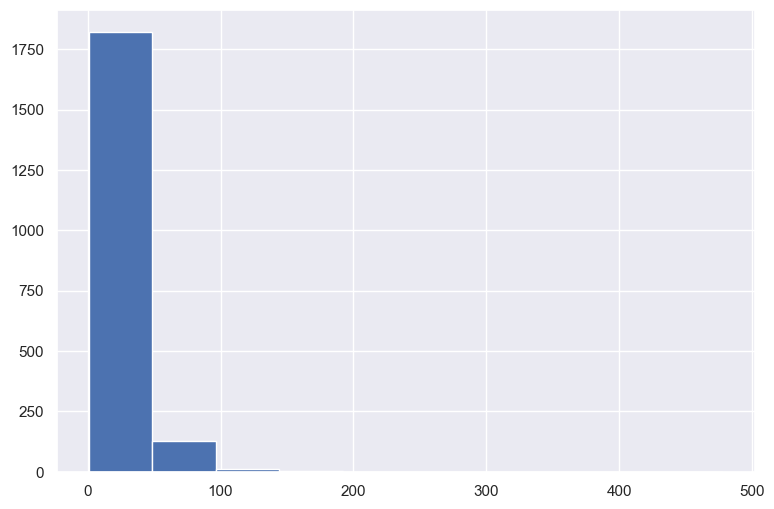

In [31]:
users_data[users_data.passed_course].day.hist()

Как видно, большинство пользователей, прошедших курс, делают это менее чем за 50 дней

Попробуем предсказать поведение пользователя на основе первых 2-х дней его пребывания на курсе

In [32]:
user_min_time = events_train.groupby('user_id', as_index=False)\
    .agg(min_timestamp = ('timestamp', 'min'))
user_min_time.head(10)

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660
5,8,1480603427
6,9,1484999434
7,11,1526140624
8,14,1436366155
9,16,1435674765


In [33]:
users_data = users_data.merge(user_min_time, how='outer')
users_data.head(10)

,user_id,last_timestamp,is_gone,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660
5,8,1481466913,True,9.0,21.0,109,84,37,156,2,False,1480603427
6,9,1484999497,True,0.0,0.0,3,3,0,4,1,False,1484999434
7,11,1526140625,False,0.0,0.0,1,0,1,1,1,False,1526140624
8,14,1436368676,True,0.0,1.0,4,3,1,9,1,False,1436366155
9,16,1513162585,True,77.0,106.0,196,196,108,651,21,True,1435674765


In [34]:
learning_time_threshold = 2 * 24 * 60 * 60
learning_time_threshold

172800

Отберем для каждого пользователя события, которые произошли в первые 2 дня после его записи на курс

In [35]:
events_train['user_time'] = events_train.user_id.map(str) + '_' + events_train.timestamp.map(str)
events_train.head(10)

,step_id,timestamp,action,user_id,date,day,user_time
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895
5,32811,1434340895,passed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895
6,32929,1434340921,discovered,17632,2015-06-15 04:02:01,2015-06-15,17632_1434340921
7,32929,1434340921,viewed,17632,2015-06-15 04:02:01,2015-06-15,17632_1434340921
8,32929,1434340939,started_attempt,17632,2015-06-15 04:02:19,2015-06-15,17632_1434340939
9,32929,1434340944,passed,17632,2015-06-15 04:02:24,2015-06-15,17632_1434340944


In [36]:
user_learning_time_threshold = user_min_time.user_id.map(str) + '_' + \
    (user_min_time.min_timestamp + learning_time_threshold).map(str)
user_min_time['user_learning_time_threshold'] = user_learning_time_threshold
user_min_time.head(10)

,user_id,min_timestamp,user_learning_time_threshold
0,1,1472827464,1_1473000264
1,2,1514383364,2_1514556164
2,3,1434358476,3_1434531276
3,5,1466156809,5_1466329609
4,7,1521634660,7_1521807460
5,8,1480603427,8_1480776227
6,9,1484999434,9_1485172234
7,11,1526140624,11_1526313424
8,14,1436366155,14_1436538955
9,16,1435674765,16_1435847565


In [37]:
events_train = events_train.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')
events_train.head(10)

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434513648
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434513648
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434513648
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434513648
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434513648
5,32811,1434340895,passed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434513648
6,32929,1434340921,discovered,17632,2015-06-15 04:02:01,2015-06-15,17632_1434340921,17632_1434513648
7,32929,1434340921,viewed,17632,2015-06-15 04:02:01,2015-06-15,17632_1434340921,17632_1434513648
8,32929,1434340939,started_attempt,17632,2015-06-15 04:02:19,2015-06-15,17632_1434340939,17632_1434513648
9,32929,1434340944,passed,17632,2015-06-15 04:02:24,2015-06-15,17632_1434340944,17632_1434513648


In [38]:
events_train = events_train[events_train.user_time <= events_train.user_learning_time_threshold]
events_train.head(10)

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434513648
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434513648
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434513648
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434513648
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434513648
5,32811,1434340895,passed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434513648
6,32929,1434340921,discovered,17632,2015-06-15 04:02:01,2015-06-15,17632_1434340921,17632_1434513648
7,32929,1434340921,viewed,17632,2015-06-15 04:02:01,2015-06-15,17632_1434340921,17632_1434513648
8,32929,1434340939,started_attempt,17632,2015-06-15 04:02:19,2015-06-15,17632_1434340939,17632_1434513648
9,32929,1434340944,passed,17632,2015-06-15 04:02:24,2015-06-15,17632_1434340944,17632_1434513648


Проверим, что число уникальных дней на тренировочной выборке корректно

In [39]:
assert events_train.groupby('user_id').day.nunique().max() <= learning_time_threshold / (24 * 60 * 60) + 1
print('OK!')

OK!


Сохраним данные за первые 2 дня и для отправок решений

In [40]:
submissions_train['users_time'] = submissions_train.user_id.map(str) + '_' + submissions_train.timestamp.map(str) 
submissions_train = submissions_train.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer') 
submissions_train = submissions_train[submissions_train.users_time <= submissions_train.user_learning_time_threshold] 

assert submissions_train.groupby('user_id').day.nunique().max() <= learning_time_threshold / (24 * 60 * 60) + 1
print('OK!')

OK!


Подготовим тренировочную выборку

Посчитаем, сколько дней каждый пользователь отправлял решения в рамках 1-х 2-х дней

In [41]:
X = submissions_train.groupby('user_id').day.nunique().to_frame().reset_index()\
    .rename(columns={'day': 'days'})
X.head(10)

,user_id,days
0,2,1
1,3,1
2,8,1
3,14,1
4,16,2
5,17,1
6,22,2
7,25,1
8,26,1
9,30,1


А также число попыток в эти 2 дня

In [42]:
steps_tried = submissions_train.groupby('user_id').step_id.nunique().to_frame().reset_index()\
    .rename(columns={'step_id': 'steps_tried'})
steps_tried.head(10)

,user_id,steps_tried
0,2,2
1,3,4
2,8,11
3,14,1
4,16,18
5,17,1
6,22,15
7,25,2
8,26,7
9,30,2


In [43]:
X = X.merge(steps_tried, on='user_id', how='outer')
X.head(10)

,user_id,days,steps_tried
0,2,1,2
1,3,1,4
2,8,1,11
3,14,1,1
4,16,2,18
5,17,1,1
6,22,2,15
7,25,1,2
8,26,1,7
9,30,1,2


Добавим сводную информацию об отправках решений

In [44]:
X = X.merge(submissions_train.pivot_table(index='user_id',
                                              columns='submission_status',
                                              values='step_id',
                                              aggfunc='count',
                                              fill_value=0).reset_index())
X.head(10)

,user_id,days,steps_tried,correct,wrong
0,2,1,2,2,0
1,3,1,4,4,4
2,8,1,11,9,21
3,14,1,1,0,1
4,16,2,18,18,23
5,17,1,1,0,2
6,22,2,15,15,9
7,25,1,2,1,4
8,26,1,7,7,16
9,30,1,2,2,0


Добавим отношение верно решенных задач ко всем отправкам

In [45]:
X['correct_ratio'] = (X.correct / (X.correct + X.wrong)).round(2)
X.head(10)

,user_id,days,steps_tried,correct,wrong,correct_ratio
0,2,1,2,2,0,1.00
1,3,1,4,4,4,0.50
2,8,1,11,9,21,0.30
3,14,1,1,0,1,0.00
4,16,2,18,18,23,0.44
5,17,1,1,0,2,0.00
6,22,2,15,15,9,0.62
7,25,1,2,1,4,0.20
8,26,1,7,7,16,0.30
9,30,1,2,2,0,1.00


Добавим сводную информацию о просмотрах пользователем степов

In [46]:
X = X.merge(events_train.pivot_table(index='user_id',
                                         columns='action',
                                         values='step_id',
                                         aggfunc='count',
                                         fill_value=0).reset_index()[['user_id', 'viewed']], how='outer')
X.head(10)

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.00,9
1,3,1.0,4.0,4.0,4.0,0.50,20
2,8,1.0,11.0,9.0,21.0,0.30,154
3,14,1.0,1.0,0.0,1.0,0.00,9
4,16,2.0,18.0,18.0,23.0,0.44,117
5,17,1.0,1.0,0.0,2.0,0.00,13
6,22,2.0,15.0,15.0,9.0,0.62,74
7,25,1.0,2.0,1.0,4.0,0.20,40
8,26,1.0,7.0,7.0,16.0,0.30,32
9,30,1.0,2.0,2.0,0.0,1.00,15


Заполним пропуски

In [47]:
X = X.fillna(0)
assert X.isnull().sum().max() == 0

Отбросим пользователей, которые проходят курс в данный момент и однозначной информации по ним нет

In [48]:
X = X.merge(users_data[['user_id', 'passed_course', 'is_gone']], how='outer')
X.head(10)

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone
0,2,1.0,2.0,2.0,0.0,1.00,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,2.0,18.0,18.0,23.0,0.44,117,True,True
5,17,1.0,1.0,0.0,2.0,0.00,13,False,True
6,22,2.0,15.0,15.0,9.0,0.62,74,True,True
7,25,1.0,2.0,1.0,4.0,0.20,40,False,False
8,26,1.0,7.0,7.0,16.0,0.30,32,False,True
9,30,1.0,2.0,2.0,0.0,1.00,15,True,True


In [49]:
X = X[~((X.is_gone == False) & (X.passed_course == False))]
X.head(10)

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone
0,2,1.0,2.0,2.0,0.0,1.00,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,2.0,18.0,18.0,23.0,0.44,117,True,True
5,17,1.0,1.0,0.0,2.0,0.00,13,False,True
6,22,2.0,15.0,15.0,9.0,0.62,74,True,True
8,26,1.0,7.0,7.0,16.0,0.30,32,False,True
9,30,1.0,2.0,2.0,0.0,1.00,15,True,True
10,31,2.0,6.0,4.0,5.0,0.44,34,False,True


Выделим зависимую переменную

In [50]:
y = X.passed_course.map(int)
y.head(10)

0     0
1     0
2     0
3     0
4     1
5     0
6     1
8     0
9     1
10    0
Name: passed_course, dtype: int64

Удалим лишнее из обучающей выборки

In [51]:
X = X.drop(['passed_course', 'is_gone'], axis=1)
X = X.set_index(X.user_id)
X = X.drop(['user_id'], axis=1)
X.head(10)

,days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.00,9
3,1.0,4.0,4.0,4.0,0.50,20
8,1.0,11.0,9.0,21.0,0.30,154
14,1.0,1.0,0.0,1.0,0.00,9
16,2.0,18.0,18.0,23.0,0.44,117
17,1.0,1.0,0.0,2.0,0.00,13
22,2.0,15.0,15.0,9.0,0.62,74
26,1.0,7.0,7.0,16.0,0.30,32
30,1.0,2.0,2.0,0.0,1.00,15


# Тренировка классификатора

In [52]:
np.random.seed(42) # для воспроизводимости экспериментов

Из тренировочных данных выделим тренировочное и тестовое подмножества

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

Создадим классификатор и определим подбираемые гиперпараметры

In [54]:
clf = CalibratedClassifierCV(estimator = RandomForestClassifier())

In [55]:
parameters = {
    'estimator__max_depth': range(1, 10, 1), 
    'estimator__min_samples_leaf': range(5, 30, 2), 
    'estimator__min_samples_split': range(2, 20, 2)
}

Инициализируем процедуру подбора гиперпараметров и запустим ее (будем оптимизировать ROC AUC)

In [56]:
searcher = HalvingGridSearchCV(clf, parameters, 
                               n_jobs=-1, scoring='roc_auc', 
                               verbose=5, cv=5, 
                               min_resources=20,
                               resource='estimator__n_estimators', max_resources=100)
searcher.__dict__

{'scoring': 'roc_auc',
 'estimator': CalibratedClassifierCV(estimator=RandomForestClassifier()),
 'n_jobs': -1,
 'refit': True,
 'cv': 5,
 'verbose': 5,
 'pre_dispatch': '2*n_jobs',
 'error_score': nan,
 'return_train_score': True,
 'random_state': None,
 'max_resources': 100,
 'resource': 'estimator__n_estimators',
 'factor': 3,
 'min_resources': 20,
 'aggressive_elimination': False,
 'param_grid': {'estimator__max_depth': range(1, 10),
  'estimator__min_samples_leaf': range(5, 30, 2),
  'estimator__min_samples_split': range(2, 20, 2)}}

In [57]:
searcher.fit(X_train, y_train)

n_iterations: 2
n_required_iterations: 7
n_possible_iterations: 2
min_resources_: 20
max_resources_: 100
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1053
n_resources: 20
Fitting 5 folds for each of 1053 candidates, totalling 5265 fits
----------
iter: 1
n_candidates: 351
n_resources: 60
Fitting 5 folds for each of 351 candidates, totalling 1755 fits


HalvingGridSearchCV(estimator=CalibratedClassifierCV(estimator=RandomForestClassifier()),
                    max_resources=100, min_resources=20, n_jobs=-1,
                    param_grid={'estimator__max_depth': range(1, 10),
                                'estimator__min_samples_leaf': range(5, 30, 2),
                                'estimator__min_samples_split': range(2, 20, 2)},
                    resource='estimator__n_estimators', scoring='roc_auc',
                    verbose=5)

In [58]:
searcher.best_params_

{'estimator__max_depth': 5,
 'estimator__min_samples_leaf': 15,
 'estimator__min_samples_split': 12,
 'estimator__n_estimators': 60}

Проверим лучший классификатор на тестовом подмножестве тренировочной выборки

In [59]:
best_clf = searcher.best_estimator_
best_clf.score(X_train, y_train)

0.9001494768310911

In [60]:
roc_auc_score(best_clf.predict(X_test), y_test)

0.7672083701076023

# Предобработка тестовых данных и прогноз на них

Проведем предобработку тестовых данных аналогично описанной выше

In [61]:
events_test = pd.read_csv('data/events_data_test.csv')
events_test.head(10)

,step_id,timestamp,action,user_id
0,30456,1526893787,viewed,24417
1,30456,1526893797,viewed,24417
2,30456,1526893954,viewed,24417
3,30456,1526895780,viewed,24417
4,30456,1526893787,discovered,24417
5,30456,1526893787,passed,24417
6,30462,1526894867,viewed,24417
7,30462,1526894886,viewed,24417
8,30462,1526895575,viewed,24417
9,30462,1526897030,viewed,24417


In [62]:
events_test['day'] = pd.to_datetime(events_test.timestamp, unit='s').dt.date
events_test.head(10)

,step_id,timestamp,action,user_id,day
0,30456,1526893787,viewed,24417,2018-05-21
1,30456,1526893797,viewed,24417,2018-05-21
2,30456,1526893954,viewed,24417,2018-05-21
3,30456,1526895780,viewed,24417,2018-05-21
4,30456,1526893787,discovered,24417,2018-05-21
5,30456,1526893787,passed,24417,2018-05-21
6,30462,1526894867,viewed,24417,2018-05-21
7,30462,1526894886,viewed,24417,2018-05-21
8,30462,1526895575,viewed,24417,2018-05-21
9,30462,1526897030,viewed,24417,2018-05-21


In [63]:
submissions_test = pd.read_csv('data/submission_data_test.csv')
submissions_test.head(10)

,step_id,timestamp,submission_status,user_id
0,31971,1526800961,wrong,24370
1,31971,1526800976,wrong,24370
2,31971,1526800993,wrong,24370
3,31971,1526801054,correct,24370
4,31972,1526800664,wrong,24370
5,31972,1526800788,wrong,24370
6,31972,1526800809,correct,24370
7,31976,1526800371,wrong,24370
8,31976,1526800399,wrong,24370
9,31976,1526800408,correct,24370


In [64]:
submissions_test['day'] = pd.to_datetime(submissions_test.timestamp, unit='s').dt.date
submissions_test.head(10)

,step_id,timestamp,submission_status,user_id,day
0,31971,1526800961,wrong,24370,2018-05-20
1,31971,1526800976,wrong,24370,2018-05-20
2,31971,1526800993,wrong,24370,2018-05-20
3,31971,1526801054,correct,24370,2018-05-20
4,31972,1526800664,wrong,24370,2018-05-20
5,31972,1526800788,wrong,24370,2018-05-20
6,31972,1526800809,correct,24370,2018-05-20
7,31976,1526800371,wrong,24370,2018-05-20
8,31976,1526800399,wrong,24370,2018-05-20
9,31976,1526800408,correct,24370,2018-05-20


In [65]:
test_users_scores = submissions_test.pivot_table(index='user_id', 
                        columns='submission_status', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()
test_users_scores.head(10)

submission_status,user_id,correct,wrong
0,12,1,0
1,13,29,36
2,15,10,30
3,21,24,103
4,35,7,35
5,45,2,0
6,55,8,3
7,58,9,3
8,62,2,1
9,74,9,7


In [66]:
test_users_data = pd.DataFrame({'user_id': events_test.user_id.unique()})
test_users_data.head(10)

,user_id
0,24417
1,999
2,26244
3,14192
4,12684
5,15393
6,13746
7,9968
8,11727
9,804


In [67]:
test_users_data = test_users_data.merge(test_users_scores, on='user_id', how='outer').fillna(0)
test_users_data.head(10)

,user_id,correct,wrong
0,24417,0.0,0.0
1,999,0.0,0.0
2,26244,0.0,0.0
3,14192,0.0,0.0
4,12684,0.0,0.0
5,15393,9.0,8.0
6,13746,0.0,0.0
7,9968,1.0,0.0
8,11727,2.0,0.0
9,804,7.0,30.0


In [68]:
test_users_events_data = events_test.pivot_table(index='user_id', 
                        columns='action', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()
test_users_events_data.head(10)

action,user_id,discovered,passed,started_attempt,viewed
0,4,1,1,0,1
1,6,1,1,0,1
2,10,2,2,0,6
3,12,11,9,4,14
4,13,70,70,35,105
5,15,1,1,0,1
6,19,1,1,0,1
7,21,74,68,70,98
8,23,1,1,0,1
9,35,34,30,11,70


In [69]:
test_users_data = test_users_data.merge(test_users_events_data, how='outer')
test_users_data.head(10)

,user_id,correct,wrong,discovered,passed,started_attempt,viewed
0,24417,0.0,0.0,33,27,6,65
1,999,0.0,0.0,6,6,0,8
2,26244,0.0,0.0,1,1,0,1
3,14192,0.0,0.0,13,13,0,22
4,12684,0.0,0.0,103,75,25,336
5,15393,9.0,8.0,14,14,0,17
6,13746,0.0,0.0,51,38,12,145
7,9968,1.0,0.0,18,15,4,37
8,11727,2.0,0.0,13,12,3,13
9,804,7.0,30.0,1,1,0,1


In [70]:
test_users_days = events_test.groupby('user_id').day.nunique().to_frame().reset_index()
test_users_days.head(10)

,user_id,day
0,4,1
1,6,1
2,10,1
3,12,1
4,13,2
5,15,1
6,19,1
7,21,2
8,23,1
9,35,3


In [71]:
test_users_data = test_users_data.merge(test_users_days, how='outer')
test_users_data.head(10)

,user_id,correct,wrong,discovered,passed,started_attempt,viewed,day
0,24417,0.0,0.0,33,27,6,65,1
1,999,0.0,0.0,6,6,0,8,1
2,26244,0.0,0.0,1,1,0,1,1
3,14192,0.0,0.0,13,13,0,22,1
4,12684,0.0,0.0,103,75,25,336,2
5,15393,9.0,8.0,14,14,0,17,1
6,13746,0.0,0.0,51,38,12,145,2
7,9968,1.0,0.0,18,15,4,37,1
8,11727,2.0,0.0,13,12,3,13,1
9,804,7.0,30.0,1,1,0,1,1


In [72]:
test_X = submissions_test.groupby('user_id').day.nunique().to_frame().reset_index()\
    .rename(columns={'day': 'days'})
test_X.head(10)

,user_id,days
0,12,1
1,13,2
2,15,3
3,21,1
4,35,3
5,45,1
6,55,1
7,58,1
8,62,1
9,74,1


In [73]:
test_steps_tried = submissions_test.groupby('user_id').step_id.nunique().to_frame().reset_index()\
    .rename(columns={'step_id': 'steps_tried'})
test_steps_tried.head(10)

,user_id,steps_tried
0,12,1
1,13,29
2,15,11
3,21,30
4,35,9
5,45,2
6,55,8
7,58,9
8,62,2
9,74,9


In [74]:
test_X = test_X.merge(test_steps_tried, on='user_id', how='outer')
test_X.head(10)

,user_id,days,steps_tried
0,12,1,1
1,13,2,29
2,15,3,11
3,21,1,30
4,35,3,9
5,45,1,2
6,55,1,8
7,58,1,9
8,62,1,2
9,74,1,9


In [75]:
test_X = test_X.merge(submissions_test.pivot_table(index='user_id',
                                              columns='submission_status',
                                              values='step_id',
                                              aggfunc='count',
                                              fill_value=0).reset_index())
test_X.head(10)

,user_id,days,steps_tried,correct,wrong
0,12,1,1,1,0
1,13,2,29,29,36
2,15,3,11,10,30
3,21,1,30,24,103
4,35,3,9,7,35
5,45,1,2,2,0
6,55,1,8,8,3
7,58,1,9,9,3
8,62,1,2,2,1
9,74,1,9,9,7


In [76]:
test_X['correct_ratio'] = (test_X.correct / (test_X.correct + test_X.wrong)).round(2)
test_X.head(10)

,user_id,days,steps_tried,correct,wrong,correct_ratio
0,12,1,1,1,0,1.00
1,13,2,29,29,36,0.45
2,15,3,11,10,30,0.25
3,21,1,30,24,103,0.19
4,35,3,9,7,35,0.17
5,45,1,2,2,0,1.00
6,55,1,8,8,3,0.73
7,58,1,9,9,3,0.75
8,62,1,2,2,1,0.67
9,74,1,9,9,7,0.56


In [77]:
test_X = test_X.merge(events_test.pivot_table(index='user_id',
                                         columns='action',
                                         values='step_id',
                                         aggfunc='count',
                                         fill_value=0).reset_index()[['user_id', 'viewed']], how='outer')
test_X.head(10)

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed
0,12,1.0,1.0,1.0,0.0,1.00,14
1,13,2.0,29.0,29.0,36.0,0.45,105
2,15,3.0,11.0,10.0,30.0,0.25,1
3,21,1.0,30.0,24.0,103.0,0.19,98
4,35,3.0,9.0,7.0,35.0,0.17,70
5,45,1.0,2.0,2.0,0.0,1.00,10
6,55,1.0,8.0,8.0,3.0,0.73,41
7,58,1.0,9.0,9.0,3.0,0.75,40
8,62,1.0,2.0,2.0,1.0,0.67,18
9,74,1.0,9.0,9.0,7.0,0.56,18


In [78]:
test_X = test_X.fillna(0)
assert test_X.isnull().sum().max() == 0

In [79]:
test_X = test_X.set_index(test_X.user_id)
test_X = test_X.drop(['user_id'], axis=1)
test_X.head(10)

,days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
12,1.0,1.0,1.0,0.0,1.00,14
13,2.0,29.0,29.0,36.0,0.45,105
15,3.0,11.0,10.0,30.0,0.25,1
21,1.0,30.0,24.0,103.0,0.19,98
35,3.0,9.0,7.0,35.0,0.17,70
45,1.0,2.0,2.0,0.0,1.00,10
55,1.0,8.0,8.0,3.0,0.73,41
58,1.0,9.0,9.0,3.0,0.75,40
62,1.0,2.0,2.0,1.0,0.67,18


Получим предсказания на тестовых данных и сохраним их в файл

In [80]:
predictions = pd.DataFrame({'user_id': test_X.index, 
                            'is_gone': best_clf.predict_proba(test_X)[:, 1]})
predictions.head(10)

,user_id,is_gone
0,12,0.054558
1,13,0.690706
2,15,0.203201
3,21,0.460797
4,35,0.148961
5,45,0.085989
6,55,0.233167
7,58,0.233009
8,62,0.068303
9,74,0.128219


In [81]:
predictions.to_csv('data/submissions/random_forest_sumbission.csv')

Полученные предсказания были загружены в проверяющую систему и получили ROC AUC равную примерно 0.8877, что является достаточно хорошим результатом в рамках таблицы лидеров

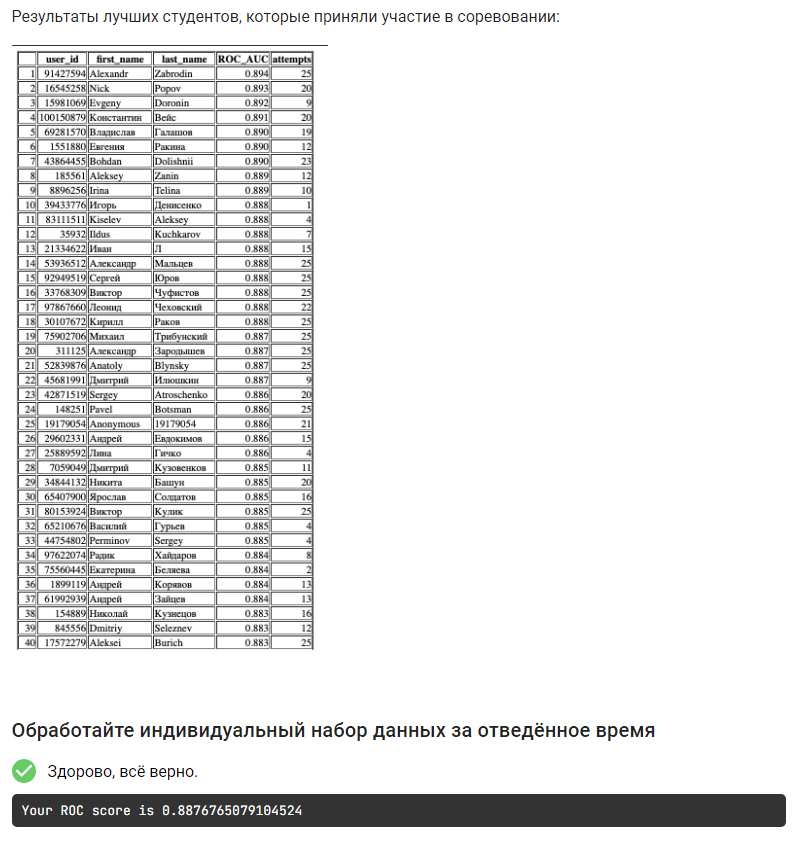

Сохраним лучший классификатор

In [82]:
import joblib

In [83]:
joblib.dump(best_clf, 'models/random_forest_course_passing_predictor.joblib')

['models/course_passing_predictor.joblib']

Протестируем работоспособность сохраненного классификатора

In [84]:
saved_clf = joblib.load('models/random_forest_course_passing_predictor.joblib')

In [85]:
saved_clf.score(X_train, y_train)

0.9001494768310911

In [86]:
roc_auc_score(saved_clf.predict(X_test), y_test)

0.7672083701076023